Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free under certain conditions — see the [`license`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

In [147]:
import logging
from itertools import combinations
from itertools import accumulate
import pandas as pd
import numpy as np
from geopy.distance import geodesic
import networkx as nx
from matplotlib import pyplot as plt

from icecream import ic

logging.basicConfig(level=logging.DEBUG)

In [148]:
CITIES = pd.read_csv('cities/vanuatu.csv', header=None, names=['name', 'lat', 'lon'])
DIST_MATRIX = np.zeros((len(CITIES), len(CITIES)))
# It return r-length tuples in sorted order with no repeated elements 
for c1, c2 in combinations(CITIES.itertuples(), 2):
    DIST_MATRIX[c1.Index, c2.Index] = DIST_MATRIX[c2.Index, c1.Index] = geodesic(
        (c1.lat, c1.lon), (c2.lat, c2.lon)
    ).km
CITIES.head()

,name,lat,lon
0,Isangel,-19.53,169.28
1,Lakatoro,-16.09,167.40
2,Longana,-15.30,168.00
3,Luganville,-15.51,167.15
4,Norsup,-16.07,167.39


## Lab2 - TSP

https://www.wolframcloud.com/obj/giovanni.squillero/Published/Lab2-tsp.nb

In [149]:
def tsp_cost(tsp):
    
    assert tsp[0] == tsp[-1]
    
    assert set(tsp) == set(range(len(CITIES)))

    tot_cost = 0
    for c1, c2 in zip(tsp, tsp[1:]):
        tot_cost += DIST_MATRIX[c1, c2]
    return tot_cost

## Greedy solution: 2-opt algorithm

### Idea

Assuming that the triangular inequality holds, we can say that if an edge crosses another one, than the 2 edges can be uncrossed in order to reduce the total length of the tour. 

We check if there are two edges that can be swapped. If we find such a pair, we swap them and repeat the process until no more improvements are made.

### References

Since I'm not really familiar with greedy solutions and how to achieve them, I've watched a video and tried to implement the concept shown.

- [2-opt explaination video](https://youtu.be/NG9CcLk7xNs?si=Iz7crSLu5yML1Nqz)
- [Wikipedia](https://en.wikipedia.org/wiki/2-opt)

In [150]:

def SwapEdges(tsp, id1, id2):
    newTsp = tsp.copy()
    #swaps the two edges: to do so we need to reverse the order of the cities between the two
    newTsp[id1+1:id2] = newTsp[id1+1:id2][::-1]      
    return newTsp    

In [151]:
def printEdge(city, closest):
    logging.debug(
        f"step: {CITIES.at[city,'name']} -> {CITIES.at[closest,'name']} ({DIST_MATRIX[city,closest]:.2f}km)"
    )

### 2-opt: version 1

This solution starts from a first greedy solution that has as first city a different city in each run. The starting cities are sorted lexicographically and the computation is truncated after being steady for a certain number of iterations.

In [152]:
def greedyFirstSolution(firstCity):
    
    city = firstCity

    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    visited[city] = True
    
    tsp = list()
    tsp.append(int(city))
    while not np.all(visited):
        dist[:, city] = np.inf
        #returns the index to the closest city
        closest = np.argmin(dist[city])
        visited[closest] = True
        city = closest
        tsp.append(int(city))
    tsp.append(tsp[0])
    return tsp
    

In [153]:
stationary = 0

firstCity = 0

minDist = np.inf

history = list()

while firstCity < len(CITIES) and stationary < len(CITIES)*len(CITIES)*10:

    newTsp = greedyFirstSolution(firstCity)
    firstCity += 1
    newDist = tsp_cost(newTsp)
    history.append(newDist)
    if(firstCity == 1):
        minDist = newDist
        tsp = newTsp
        logging.info(f"First greedy result: Found a path of {len(tsp)-1} steps, total length {newDist:.2f}km")
    if(newDist < minDist):
        minDist = newDist
        tsp = newTsp
        
    for i in range(0,len(CITIES)-1):
        for j in range (i+1,len(CITIES)):
            newTsp = SwapEdges(tsp, i, j)
            newDist = tsp_cost(newTsp)
            history.append(newDist)  
            if(newDist < minDist):
               minDist = newDist
               tsp = newTsp
               i=0
               j=i+1
               stationary = 0
               break
            else:
                stationary += 1      

   
logging.info(f"2-opt result: Found a path of {len(tsp)-1} steps, total length {minDist:.2f}km")

INFO:root:First greedy result: Found a path of 8 steps, total length 1475.53km
INFO:root:2-opt result: Found a path of 8 steps, total length 1475.53km


Isangel 1475.528091104531 km
Lakatoro 1481.4725995315478 km
Longana 1515.4351529055762 km
Luganville 1536.8597836386598 km
Norsup 1486.3844178502513 km
Port Olry 1604.0534064899764 km
Sola 1519.3524138249309 km
Vila 1475.5280911045313 km


### Results

* Vanuatu: 1475.53 km
* Italy: 4263.21 km
* Russia: 35096.52 km
* US: 42839.77 km
* China: 55688.03 km

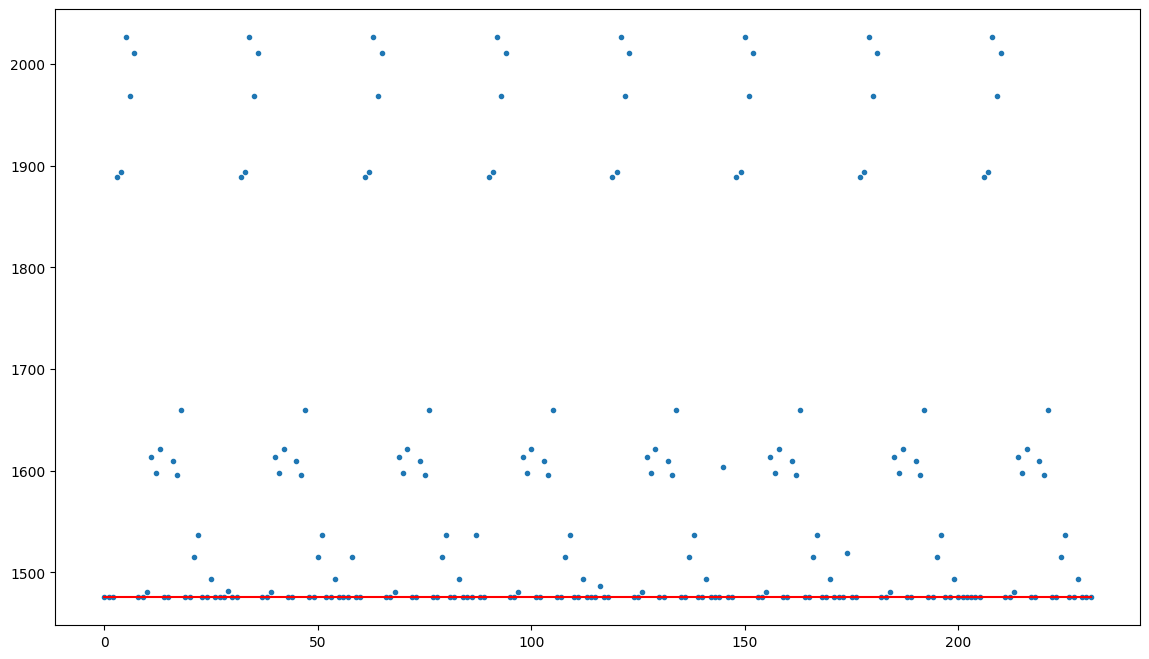

In [154]:
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, min)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

### 2-opt: version 2

I use the greedy algorithm to find a first solution to the problem. The greedy algorithm starts from a random city and at each step selects the nearest city that has not been visited yet. 
In order to avoid starting from the same city in each run, I keep track of the cities from which I have already started and I start from a random city among the ones that have not been visited yet. 


In [155]:
def greedyFirstSolution(canStartFrom):
    
    #checks if we already started the computation from all the cities
    if np.all(canStartFrom == False):
        canStartFrom = np.full(len(CITIES), True)
      
    #chooses a random city to start from among the ones that have not been visited yet  
    city = np.random.choice(np.where(canStartFrom)[0])
    canStartFrom[city] = False

    visited = np.full(len(CITIES), False)
    dist = DIST_MATRIX.copy()
    visited[city] = True
    
    tsp = list()
    tsp.append(int(city))
    while not np.all(visited):
        dist[:, city] = np.inf
        closest = np.argmin(dist[city])
        visited[closest] = True
        city = closest
        tsp.append(int(city))
    tsp.append(tsp[0])
    return tsp

In [156]:
stationary = 0
firstCity=0
canStartFrom = np.full(len(CITIES), True)

minDist = np.inf
history = list()

while stationary < len(CITIES)*len(CITIES)*10:

    newTsp = greedyFirstSolution(canStartFrom)
    newDist = tsp_cost(newTsp)
    history.append(newDist)
    if(firstCity == 0):
        minDist = newDist
        tsp = newTsp
        firstCity += 1
        logging.info(f"First greedy result: Found a path of {len(tsp)-1} steps, total length {newDist:.2f}km")
    if(newDist < minDist):
        minDist = newDist
        tsp = newTsp
        
    for i in range(0,len(CITIES)-1):
        for j in range (i+1,len(CITIES)):
            newTsp = SwapEdges(tsp, i, j)
            newDist = tsp_cost(newTsp)
            history.append(newDist)  
            #print(newDist,"km", "i: ", i, "j: ", j)
            if(newDist < minDist):
               minDist = newDist
               tsp = newTsp
               i=0
               j=i+1
               stationary = 0
               break
            else:
                stationary += 1      

   
logging.info(f"2-opt result: Found a path of {len(tsp)-1} steps, total length {minDist:.2f}km")

INFO:root:First greedy result: Found a path of 8 steps, total length 1536.86km
INFO:root:2-opt result: Found a path of 8 steps, total length 1420.31km


### Results

* Vanuatu: 1345.54 km
* Italy: 4256.00 km
* Russia: 34165.47 km (lucky round, I only obtained this result once)
* US: 41011.24 km
* China: 54772.67 km

## Visualization

### Distance visualization

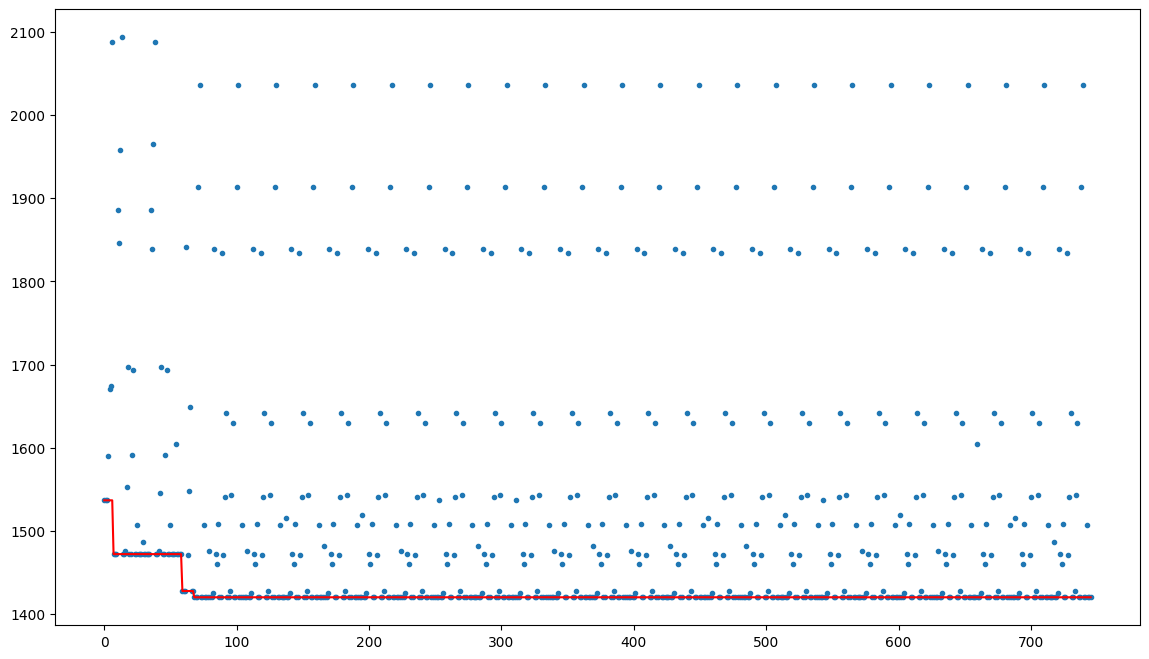

In [157]:
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, min)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

### Network visualization

In this visualization the red line represents the chosen path. The edges have different width based on the distance between the two cities.

This visualization is useful only for small instances of the problem, as the network becomes too dense for larger instances.

### Resources

- [Networkx docs and gallery](https://networkx.org/documentation/stable/auto_examples/index.html)

I tried to visualize the graph using the Pyvis library, but it was not responding to my needs and it was kind of overkill for this task. Since it could be useful in the future, I'll leave the link to a usage guide here:

- [Pyvis usage guide](https://medium.com/@stephanhausberg/graph-networks-visualization-with-pyvis-and-keyword-extraction-cd973d372e2c)

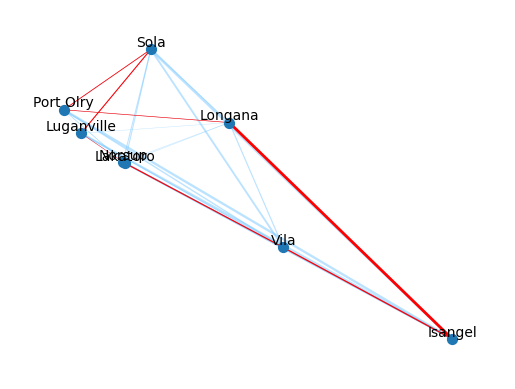

<Figure size 1400x800 with 0 Axes>

In [ ]:
EDGE_SIZE = 2

G = nx.Graph()
tspEdges = [(CITIES.at[tsp[i], 'name'], CITIES.at[tsp[i+1], 'name']) for i in range(len(tsp)-1)]
tspWidth = [DIST_MATRIX[tsp[i], tsp[i+1]] for i in range(len(tsp)-1)]
tspWidth = [(w/np.max(tspWidth))*EDGE_SIZE for w in tspWidth]


for i in range (len(CITIES)-1):
    for j in range (i+1, len(CITIES)):
        if(i!=j):
            G.add_edge(CITIES.at[i, 'name'], CITIES.at[j, 'name'], value=DIST_MATRIX[i,j])
            

pos = {CITIES.at[i, 'name']: (CITIES.at[i, 'lon'], CITIES.at[i, 'lat']) for i in range(len(CITIES))}

#draw nodes
nx.draw_networkx_nodes(G, pos, node_size=50)


# edge width is proportional number of games played
edgewidth = [d['value'] for (u,v,d) in G.edges(data=True)]
edgewidth = [(w/np.max(edgewidth))*EDGE_SIZE for w in edgewidth]

    
nx.draw_networkx_edges(G, pos, edgelist=tspEdges, width=tspWidth, edge_color='red')

if(len(CITIES)<15):
    #draws all the edges
    nx.draw_networkx_edges(G, pos, width=edgewidth, alpha=0.5, edge_color='#78c7ff') 
    #node labels
    nx.draw_networkx_labels(G, pos, verticalalignment='bottom', font_size=10, font_family='sans-serif') 
    #edge weight labels -> too messy for large graphs
    edge_labels = nx.get_edge_attributes(G, 'value')
    edge_labels = {k: f"{v:.2f}" for k, v in edge_labels.items()}
    nx.draw_networkx_edge_labels(G, pos, font_size=2, edge_labels=edge_labels)


ax = plt.gca()
ax.margins(0.08)
plt.axis("off")
plt.figure(figsize=(14, 8))
plt.show()